# Stock Sentiment Analysis - Reddit vs the News

## 4. Data Modeling

#### Created By: Ben Chamblee - https://github.com/Bench-amblee

### Contents
- [Introduction](#introduction)
- [Imports](#imports)
- [Load and Evaluate Data](#load-and-evaluate-data)
- [Confusion Matrices](#confusion-matrices)
- [Model Setup and Feature Sets](#model-setup-and-feature-sets)
- [Model Training and Evaluation](#model-training-and-evaluation)
- [Model Analysis: Reddit Data](#model-analysis-reddit-data)
- [Model Analysis: News Data](#model-analysis-news-data)
- [Hyperparameters and Model Optimization](#hyperparameters-and-model-optimization)
- [Feature Contribution Analysis](#feature-contribution-analysis)
- [Findings and Model Justification](#findings-and-model-justification)
- [Weighted Ensemble Model](#weighted-ensemble-model)
- [Deployment Considerations and Next Steps](#deployment-considerations-and-next-steps)
- [Conclusion](#conclusion)

<a id="introduction"></a>
### Introduction

This notebook documents the data modeling processing methodologies used to evaluate Reddit sentiment data and sentiment data sourced from the NewsAPI. This phase focuses on evaluating models, calculating accuracy, and developing a final model.

The primary objectives of this notebook are to:

- Finalize feature selections to determine correlation
- Evaluate multiple model types to determine the best one
- Optimize model performance and evalute accuracy
- Evaluate accuracy performance and make final adjustments
- Export model for further development or deployment

<a id="imports"></a>
### Imports

In [ ]:
import pandas as pd # Data manipulation library providing DataFrame structures
import numpy as np # Numerical computing library for mathematical operations and arrays
from sklearn.ensemble import RandomForestClassifier # Implements Random Forest algorithm
from sklearn.linear_model import LogisticRegression # Implements Logistic Regression algorithm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Model evaluation metrics
from sklearn.preprocessing import StandardScaler # Standardizes features by removing mean and scaling to unit variance
from sklearn.model_selection import GridSearchCV # Hyperparameter tuning with cross-validation
import matplotlib.pyplot as plt # Visualization library for creating graphs
import seaborn as sns # Statistical data visualization based on matplotlib
import pickle # Serializes Python objects for saving and loading models
import warnings # For handling warning messages

import warnings # For handling warning messages
warnings.filterwarnings('ignore')


# Set plot style for visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# For cleaner visualizations
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

<a id="load-and-evaluate-data"></a>
### Load and Evaluate Data

Let's load our processed data from the previous step and take a look at our key columns

In [247]:
# Load datasets
reddit_data = pd.read_csv('../data/magnificent7_data/reddit_sentiment_model_data.csv')
news_data = pd.read_csv('../data/magnificent7_data/news_sentiment_model_data.csv')

Now lets further clean up our data and get a baseline accuracy for our predicted direction (up, down, or flat) vs the actual direction of the stock

In [248]:
# Convert string booleans to actual booleans
bool_columns = ['sentiment_compound_is_filled', 'prev_day_sentiment_compound_is_filled', 
                'no_post_prediction', 'is_quarter_end']

for col in bool_columns:
    if col in reddit_data.columns:
        reddit_data[col] = reddit_data[col].map({'True': True, 'False': False})
        news_data[col] = news_data[col].map({'True': True, 'False': False})

# Examine the key columns: next_day_direction vs predicted_direction
print("\nReddit - Predicted vs Actual Direction:")
reddit_comparison = pd.crosstab(reddit_data['predicted_direction'], 
                               reddit_data['next_day_direction'], 
                               normalize='index')
print(reddit_comparison)

print("\nNews API - Predicted vs Actual Direction:")
news_comparison = pd.crosstab(news_data['predicted_direction'], 
                             news_data['next_day_direction'], 
                             normalize='index')
print(news_comparison)

# Calculate accuracy of predicted_direction vs next_day_direction
prediction_accuracy = (reddit_data['predicted_direction'] == news_data['next_day_direction']).mean()

print(f"Initial prediction accuracy: {prediction_accuracy:.4f}")



Reddit - Predicted vs Actual Direction:
next_day_direction       down      flat        up
predicted_direction                              
down                 0.452555  0.198905  0.348540
flat                 0.335714  0.359524  0.304762
up                   0.294194  0.296774  0.409032

News API - Predicted vs Actual Direction:
next_day_direction       down      flat        up
predicted_direction                              
down                 0.619048  0.000000  0.380952
flat                 0.400000  0.600000  0.000000
up                   0.000000  0.303411  0.696589
Initial prediction accuracy: 0.4108


Looks like overall the prediction accuracy is 41% which is low but not terrible - remember this is just with one simple feature. We'll develop this further while we do modeling and feature selection but this is a good baseline.

<a id="confusion-matrices"></a>
### Confusion Matrices

Lets visualize the difference between each source as well using a confusion matrix

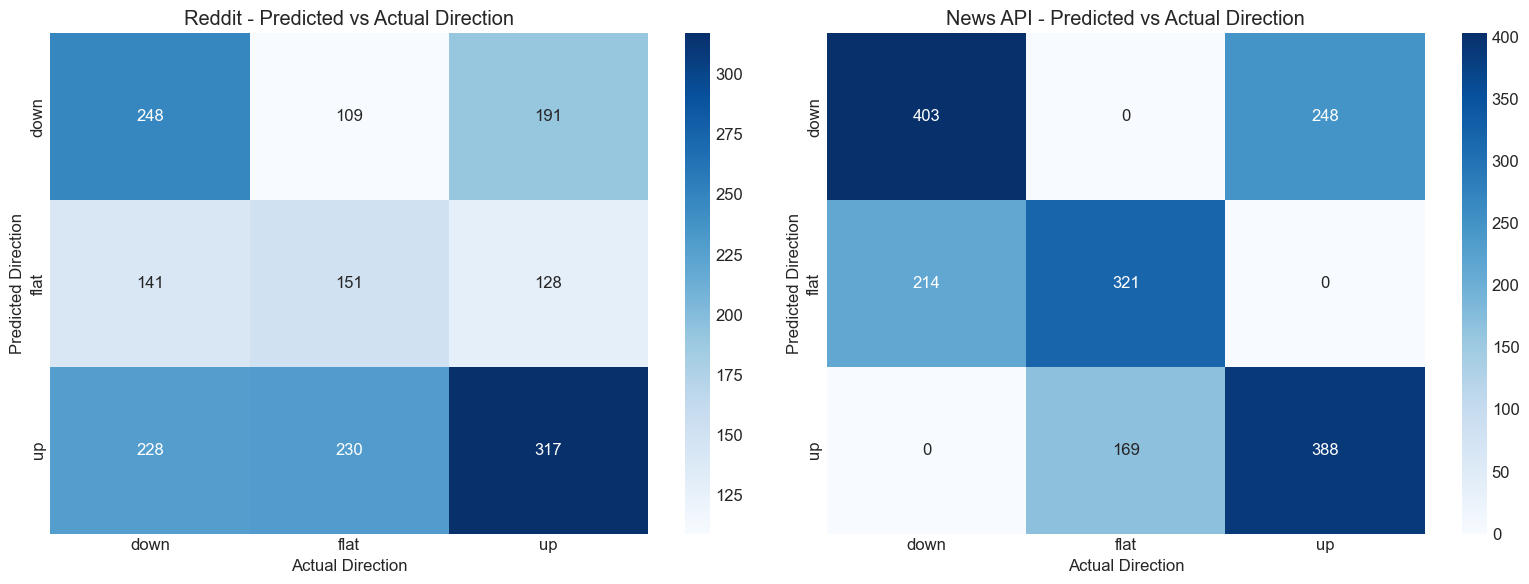

In [249]:
# Visualize prediction accuracy for both sources
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Reddit confusion matrix
sns.heatmap(pd.crosstab(reddit_data['predicted_direction'], reddit_data['next_day_direction']),
            annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Reddit - Predicted vs Actual Direction')
ax1.set_xlabel('Actual Direction')
ax1.set_ylabel('Predicted Direction')

# News API confusion matrix
sns.heatmap(pd.crosstab(news_data['predicted_direction'], news_data['next_day_direction']),
            annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('News API - Predicted vs Actual Direction')
ax2.set_xlabel('Actual Direction')
ax2.set_ylabel('Predicted Direction')

plt.tight_layout()
plt.show()


In general - the news looks more accurate, but this is still with just one feature

Lets take a look at our other features including compound sentiment, positive sentiment, negative sentiment, and 7-day average sentiment

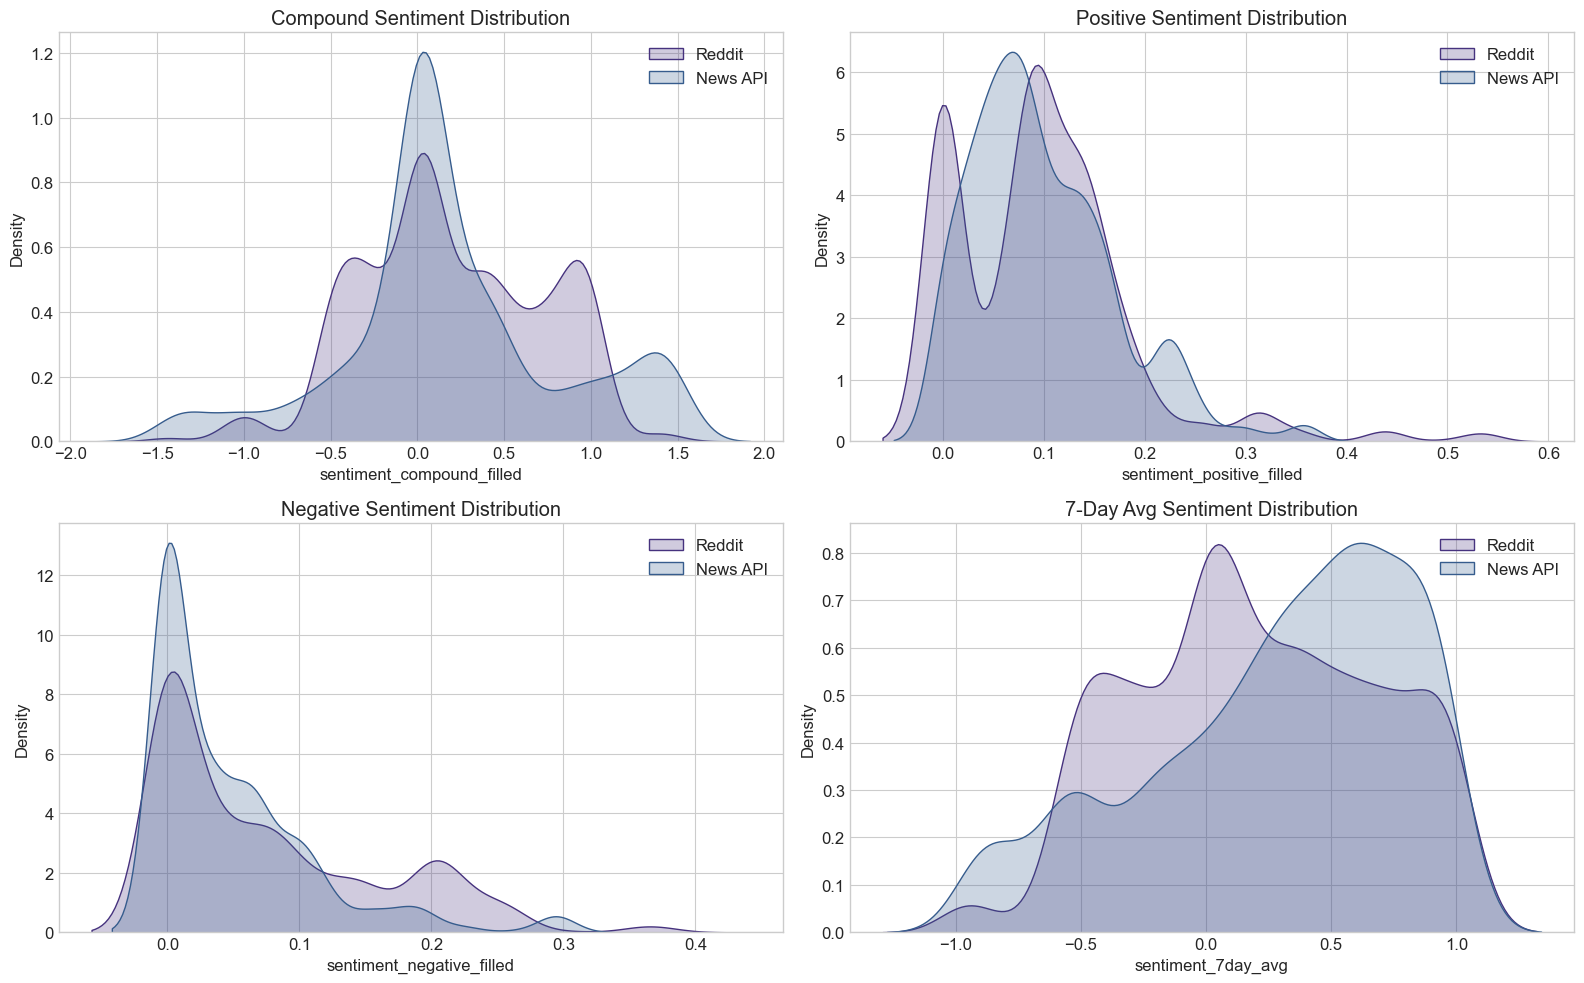

In [250]:
# Compare sentiment scores between Reddit and News
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Compound sentiment
sns.kdeplot(data=reddit_data, x='sentiment_compound_filled', ax=axes[0, 0], label='Reddit', fill=True)
sns.kdeplot(data=news_data, x='sentiment_compound_filled', ax=axes[0, 0], label='News API', fill=True)
axes[0, 0].set_title('Compound Sentiment Distribution')
axes[0, 0].legend()

# Positive sentiment
sns.kdeplot(data=reddit_data, x='sentiment_positive_filled', ax=axes[0, 1], label='Reddit', fill=True)
sns.kdeplot(data=news_data, x='sentiment_positive_filled', ax=axes[0, 1], label='News API', fill=True)
axes[0, 1].set_title('Positive Sentiment Distribution')
axes[0, 1].legend()

# Negative sentiment
sns.kdeplot(data=reddit_data, x='sentiment_negative_filled', ax=axes[1, 0], label='Reddit', fill=True)
sns.kdeplot(data=news_data, x='sentiment_negative_filled', ax=axes[1, 0], label='News API', fill=True)
axes[1, 0].set_title('Negative Sentiment Distribution')
axes[1, 0].legend()

# 7-day average sentiment
sns.kdeplot(data=reddit_data, x='sentiment_7day_avg', ax=axes[1, 1], label='Reddit', fill=True)
sns.kdeplot(data=news_data, x='sentiment_7day_avg', ax=axes[1, 1], label='News API', fill=True)
axes[1, 1].set_title('7-Day Avg Sentiment Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Now lets do another confusion matrix with these features and some other important features

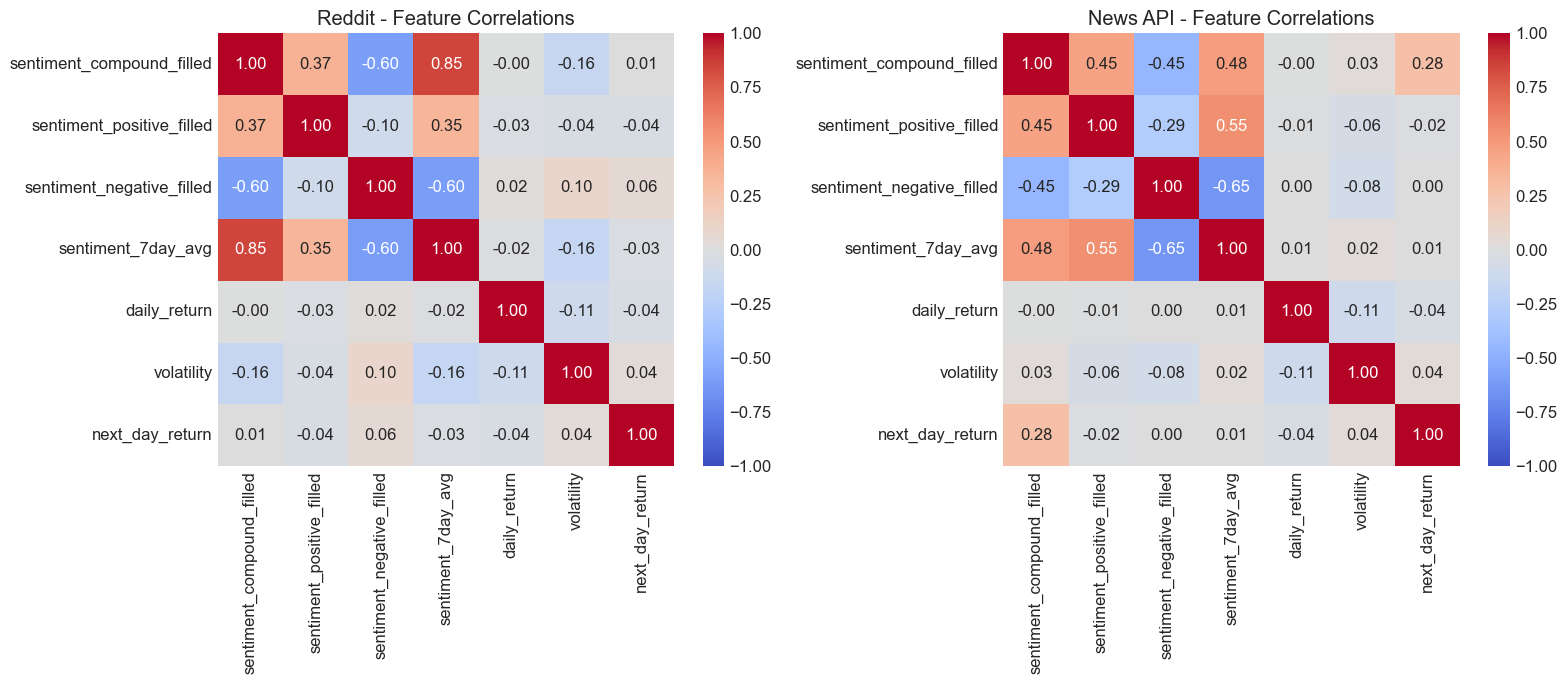

In [ ]:
# Select relevant features for correlation analysis
correlation_features = [
    'sentiment_compound_filled', 'sentiment_positive_filled', 
    'sentiment_negative_filled', 'sentiment_7day_avg', 
    'daily_return', 'volatility', 'next_day_return'
]

reddit_corr = reddit_data[correlation_features].corr()
news_corr = news_data[correlation_features].corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Reddit correlations
sns.heatmap(reddit_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax1, fmt='.2f')
ax1.set_title('Reddit - Feature Correlations')

# News API correlations
sns.heatmap(news_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2, fmt='.2f')
ax2.set_title('News API - Feature Correlations')

plt.tight_layout()
plt.show()

It looks like we should be able to use these features for our overall evaluation and correlation shouldn't result in any overfitting

<a id="model-setup-and-feature-sets"></a>
### Model Setup and Feature Sets

Now that we've evaluated and look at an initial accuracy of 41% (based on predicted outcome alone), we can add additional features and begin our model development

For our model we'll create a train/test split with a test size of 30% - because we're using time based data we'll have to make sure the dates selected for our prediction data match with the actual stock data as well

Last, we'll define functions to quickly visualize and evalute models with another confusion matrix and feature importance heatmap - this way we can evaluate multiple models at the same time 

In [252]:
# Define feature sets for comparison
sentiment_features = [
    'sentiment_compound_filled',
    'sentiment_positive_filled', 
    'sentiment_negative_filled',
    'sentiment_7day_avg'
]

# Create One-Hot encoded version of predicted_direction
reddit_data_encoded = pd.get_dummies(reddit_data, columns=['predicted_direction'], prefix='pred')
news_data_encoded = pd.get_dummies(news_data, columns=['predicted_direction'], prefix='pred')

# Define prediction features (one-hot encoded)
prediction_features = [col for col in reddit_data_encoded.columns if col.startswith('pred_')]
print("\nPrediction features:", prediction_features)

# Combined feature sets
combined_features = sentiment_features + ['post_count_filled']
combined_with_prediction = combined_features + prediction_features

# Function for chronological train/test split
def time_split(df, test_size=0.3):
    # Sort by date
    df = df.sort_values(by='date_only')
    split_idx = int(len(df) * (1-test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    return train, test

# Check the time range in each set
reddit_train, reddit_test = time_split(reddit_data_encoded)
print(f"\nTrain dates: {reddit_train['date_only'].min()} to {reddit_train['date_only'].max()}")
print(f"Test dates: {reddit_test['date_only'].min()} to {reddit_test['date_only'].max()}")


# Function to prepare dataset for modeling
def prepare_data(data_source, features):
    # Use time-based split
    train, test = time_split(data_source)
    
    # Select features and target
    X_train = train[features]
    y_train = train['next_day_direction']
    X_test = test[features]
    y_test = test['next_day_direction']
    
    # Scale numerical features
    numerical_features = [f for f in features if f not in prediction_features]
    if numerical_features:
        scaler = StandardScaler()
        X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
        X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    
    return X_train, X_test, y_train, y_test


# Visualization functions
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['down', 'flat', 'up'],
                yticklabels=['down', 'flat', 'up'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_feature_importance(importances, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()


Prediction features: ['pred_down', 'pred_flat', 'pred_up']

Train dates: 2024-03-01 to 2024-11-07
Test dates: 2024-11-07 to 2025-02-27


### Model Training and Evaluation

Now that our train/test split is defined and our evaluation functions are ready we can train two classification models: Random Forest and Logistic Regression and determine which one performs better

evaluate_model compares Random Forest and Logistic Regression for classification performance

- Trains both models using predefined training data
- Calculate accuracy scores for both models
- Identify and rank feature importance
- Creates visualizations for evaluation
- Selects better performing model based on overall accuracy

In [253]:
# Function to train models and evaluate performance
def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    print(f"\n{model_name} Results:")
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=711)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    
    # Train Logistic Regression
    lr = LogisticRegression(max_iter=1000, random_state=711)
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_pred)
    
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
    
    # Get feature importances from Random Forest
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importances
    plot_feature_importance(importances, f"{model_name} - Feature Importance")
    
    # Determine best model and plot confusion matrix
    if rf_accuracy >= lr_accuracy:
        print("\nRandom Forest Classification Report:")
        print(classification_report(y_test, rf_pred))
        plot_confusion_matrix(y_test, rf_pred, f"{model_name} - Random Forest Confusion Matrix")
        best_model = rf
        best_pred = rf_pred
    else:
        print("\nLogistic Regression Classification Report:")
        print(classification_report(y_test, lr_pred))
        plot_confusion_matrix(y_test, lr_pred, f"{model_name} - Logistic Regression Confusion Matrix")
        best_model = lr
        best_pred = lr_pred
    
    return {
        'rf_accuracy': rf_accuracy,
        'lr_accuracy': lr_accuracy,
        'importances': importances,
        'best_model': best_model,
        'predictions': best_pred,
        'true_values': y_test
    }

<a id="model-analysis-reddit-data"></a>
### Model Analysis: Reddit Data

Let's see the results of the model evaluation function using just the Reddit data

We'll do two version of the evaluation - one with just sentiment features and another with sentiment features and our prediction feature


===== REDDIT SENTIMENT MODEL ANALYSIS =====

Reddit - Sentiment Features Only Results:
Random Forest Accuracy: 0.3384
Logistic Regression Accuracy: 0.3843


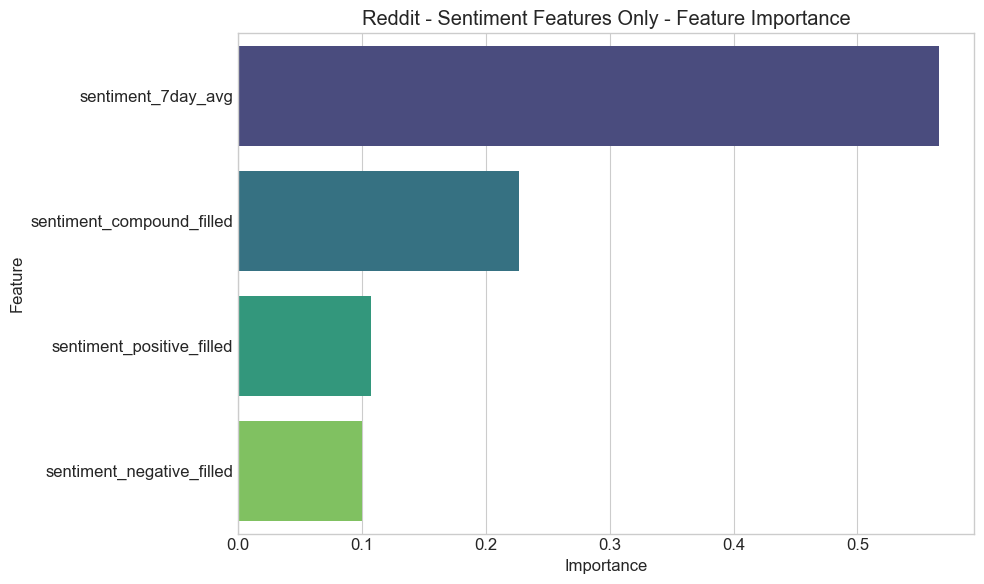


Logistic Regression Classification Report:
              precision    recall  f1-score   support

        down       0.48      0.42      0.45       190
        flat       0.28      0.25      0.26       140
          up       0.37      0.45      0.41       193

    accuracy                           0.38       523
   macro avg       0.38      0.37      0.37       523
weighted avg       0.39      0.38      0.38       523



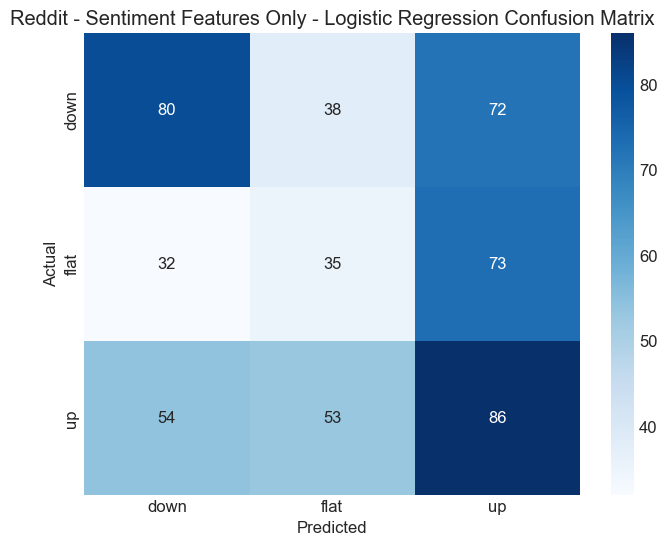

In [254]:
print("\n===== REDDIT SENTIMENT MODEL ANALYSIS =====")

X_train, X_test, y_train, y_test = prepare_data(reddit_data_encoded, sentiment_features)
reddit_sentiment_results = evaluate_model(X_train, X_test, y_train, y_test, "Reddit - Sentiment Features Only")

<a id="model-analysis-news-data"></a>
### Model Analysis: News Data

Let's do the same for our news data


===== NEWS API SENTIMENT MODEL ANALYSIS =====

News API - Sentiment Features Only Results:
Random Forest Accuracy: 0.6061
Logistic Regression Accuracy: 0.5354


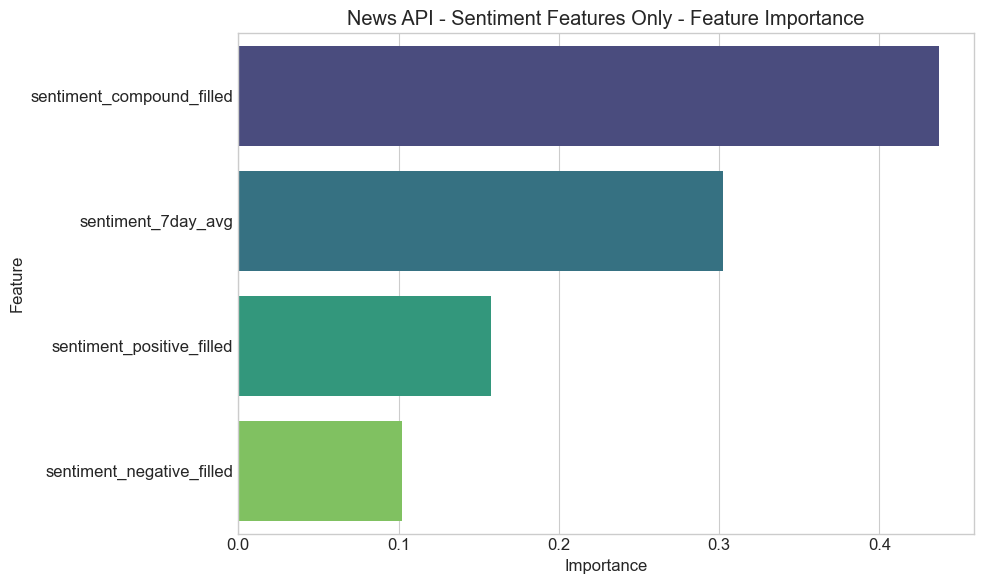


Random Forest Classification Report:
              precision    recall  f1-score   support

        down       0.58      0.61      0.60       190
        flat       0.59      0.54      0.57       140
          up       0.64      0.65      0.64       193

    accuracy                           0.61       523
   macro avg       0.60      0.60      0.60       523
weighted avg       0.61      0.61      0.61       523



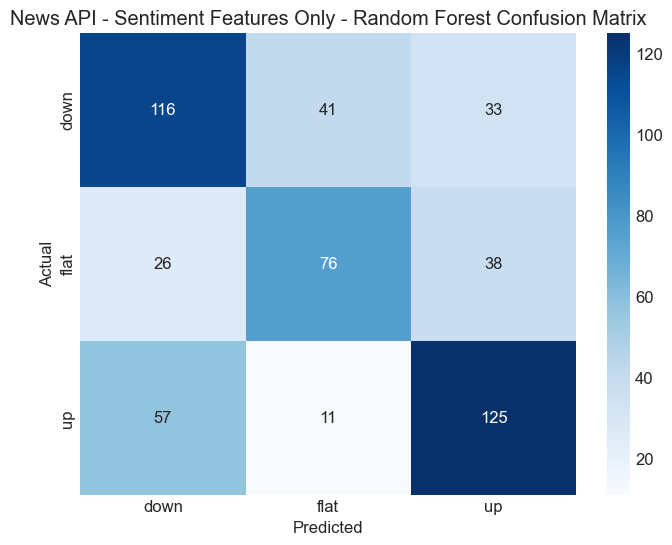

In [255]:
print("\n===== NEWS API SENTIMENT MODEL ANALYSIS =====")

X_train, X_test, y_train, y_test = prepare_data(news_data_encoded, sentiment_features)
news_sentiment_results = evaluate_model(X_train, X_test, y_train, y_test, "News API - Sentiment Features Only")

The Random Forest model has given our best initial result (~61% with NewsAPI), lets focus on that and try optimizing hyperparameters as well as adding in the prediction feature from before

<a id="hyperparameters-and-model-optimization"></a>
### Hyperparameters and Model Optimization

this final modeling function will tune five important hyperparameters and output with the best result. The five hyperparameters are:
- n_estimators: Number of trees in the forest
- max_depth: Maximum depth of the trees
- min_samples_split: Minimum samples required to split a node
- min_samples_leaf: Minimum samples required at a leaf node
- max_features: Number of features to consider for the best split

In [ ]:
def evaluate_rf_model_with_tuning(X_train, X_test, y_train, y_test, model_name):
    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    # Create a base random forest model
    rf = RandomForestClassifier(random_state=711)
    
    # Setup GridSearchCV
    print(f"\nPerforming GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,  # Use all available cores
        verbose=1,
        scoring='accuracy'
    )
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and score
    print(f"\nBest parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Get the best model
    best_rf = grid_search.best_estimator_
    
    # Evaluate on test set
    rf_pred = best_rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    
    # Create a clean, focused summary
    print("\n" + "="*50)
    print(f"BEST MODEL SUMMARY FOR {model_name}")
    print("="*50)
    print(f"Best Random Forest model achieved {rf_accuracy:.4f} accuracy on the test set")
    print("\nOptimal parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  • {param}: {value}")
    print("\nCross-validation score: {:.4f}".format(grid_search.best_score_))
    print("="*50)
    
    # Get feature importances from the best Random Forest
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Create a dataframe of top 10 results from grid search
    top_results = pd.DataFrame(grid_search.cv_results_)
    top_results = top_results.sort_values(by='rank_test_score').head(10)
    
    # Select only relevant columns for readability
    top_results = top_results[[
        'params', 
        'mean_test_score', 
        'std_test_score', 
        'rank_test_score'
    ]]
    
    print("\nTop 10 parameter combinations:")
    print(top_results)
    
    return {
        'rf_accuracy': rf_accuracy,
        'importances': importances,
        'best_model': best_rf,
        'predictions': rf_pred,
        'true_values': y_test,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'grid_search': grid_search,
        'top_results': top_results
    }

In [257]:
# Reddit Combined features with prediction
X_train, X_test, y_train, y_test = prepare_data(reddit_data_encoded, combined_with_prediction)
reddit_combined_pred_results = evaluate_rf_model_with_tuning(X_train, X_test, y_train, y_test, "Reddit - Combined Features with Prediction")

# News Combined features with prediction
X_train, X_test, y_train, y_test = prepare_data(news_data_encoded, combined_with_prediction)
news_combined_pred_results = evaluate_rf_model_with_tuning(X_train, X_test, y_train, y_test, "News API - Combined Features with Prediction")


Performing GridSearchCV for Reddit - Combined Features with Prediction...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.3738

BEST MODEL SUMMARY FOR Reddit - Combined Features with Prediction
Best Random Forest model achieved 0.4379 accuracy on the test set

Optimal parameters:
  • max_depth: 10
  • max_features: sqrt
  • min_samples_leaf: 4
  • min_samples_split: 2
  • n_estimators: 100

Cross-validation score: 0.3738

Top 10 parameter combinations:
                                                params  mean_test_score  \
97   {'max_depth': 10, 'max_features': 'sqrt', 'min...         0.373770   
101  {'max_depth': 10, 'max_features': 'sqrt', 'min...         0.373770   
137  {'max_depth': 10, 'max_features': 'log2', 'min...         0.372131   
133  {'max_depth': 10, 'max_features': 'log2', 'min...       

#### Hyperparameter Tuning Results

After tuning our hyperparameters we've got a noticible improvement for both our models

- Reddit best model before tuning hyperparameters: 33.4%
- After tuning hyperparameters: 43.8% 
    - Difference: +10.4%

- NewsAPI best model before tuning hyperparameters: 60.6%
- After tuning hyperparameters: 63.5%
    - Difference: +2.9%

This makes a huge difference in our accuracy!

Let's visualize it

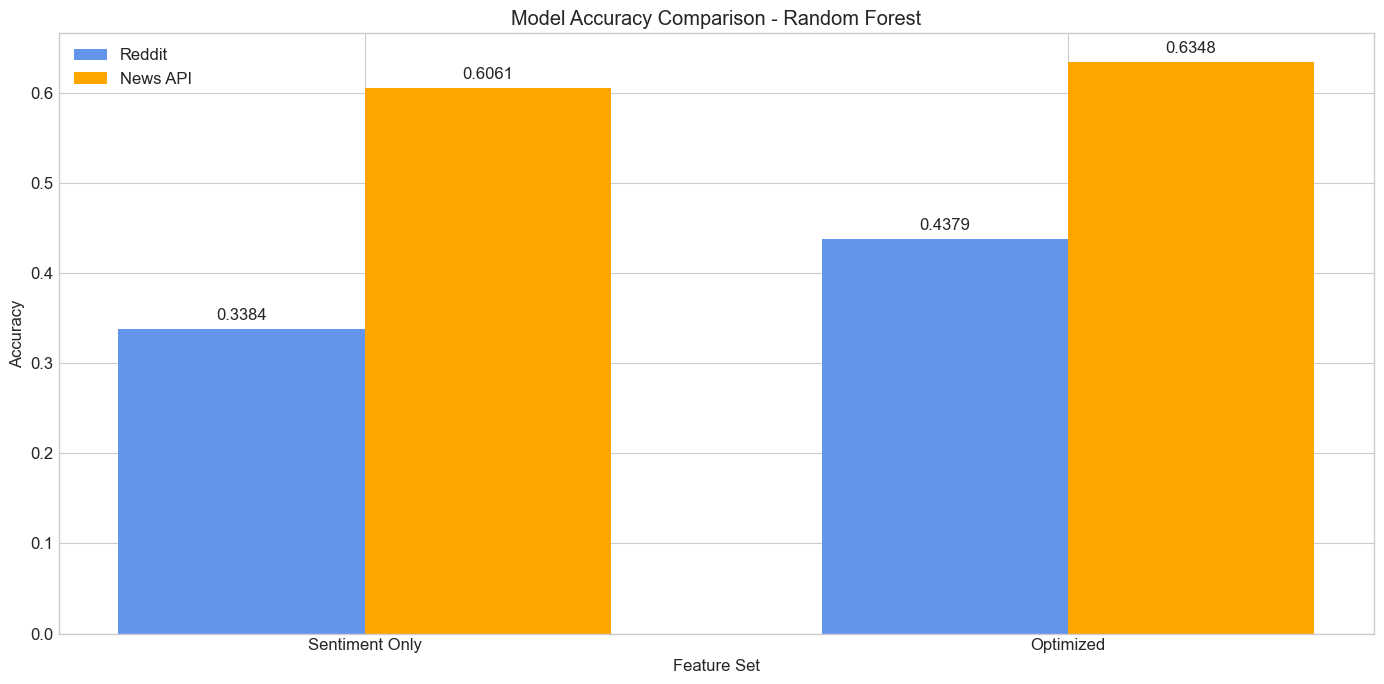

In [270]:
# Compare model accuracies across all feature sets
model_names = ['Sentiment Only', 'Optimized']
reddit_rf_accuracies = [
    reddit_sentiment_results['rf_accuracy'], 
    reddit_combined_pred_results['rf_accuracy']
]
news_rf_accuracies = [
    news_sentiment_results['rf_accuracy'], 
    news_combined_pred_results['rf_accuracy']
]

plt.figure(figsize=(14, 7))
bar_width = 0.35
x = np.arange(len(model_names))

plt.bar(x - bar_width/2, reddit_rf_accuracies, bar_width, label='Reddit', color='cornflowerblue')
plt.bar(x + bar_width/2, news_rf_accuracies, bar_width, label='News API', color='orange')

plt.xlabel('Feature Set')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison - Random Forest')
plt.xticks(x, model_names)
plt.legend()

# Add accuracy values on bars
for i, v in enumerate(reddit_rf_accuracies):
    plt.text(i - bar_width/2, v + 0.01, f'{v:.4f}', ha='center')
    
for i, v in enumerate(news_rf_accuracies):
    plt.text(i + bar_width/2, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

In [271]:
# Create a dataframe for comparing accuracies across all models
comparison_df = pd.DataFrame({
    'Feature Set': model_names,
    'Reddit - RF': reddit_rf_accuracies,
    'News API - RF': news_rf_accuracies,
})

# Display as a styled table
print("\nAccuracy Comparison Table:")
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


Accuracy Comparison Table:
   Feature Set  Reddit - RF  News API - RF
Sentiment Only       0.3384         0.6061
     Optimized       0.4379         0.6348


Great - lets move on to quickly analyzing the feature contributions

<a id="feature-contribution-analysis"></a>
### Feature Contribution Analysis

There's two main things we want to look at
1. What difference does adding the prediction feature make vs a regular random forest model?
2. How much better is our optimized model than if we just used the raw prediction data?

In [285]:
# Calculate improvement from adding prediction features
reddit_combined_acc = reddit_sentiment_results['rf_accuracy']
reddit_combined_pred_acc = reddit_combined_pred_results['rf_accuracy']
reddit_prediction_improvement = (reddit_combined_pred_acc - reddit_combined_acc) / reddit_combined_acc * 100

news_combined_acc = news_sentiment_results['rf_accuracy']
news_combined_pred_acc = news_combined_pred_results['rf_accuracy']
news_prediction_improvement = (news_combined_pred_acc - news_combined_acc) / news_combined_acc * 100

print("\n===== PREDICTION FEATURE CONTRIBUTION =====")
print("1. Prediction feature impact:")
print(f"Reddit: Adding prediction features improves accuracy by {reddit_prediction_improvement:.2f}%")
print(f"News API: Adding prediction features improves accuracy by {news_prediction_improvement:.2f}%")
print("")

# Compare base models against raw prediction accuracy
reddit_raw_prediction_accuracy = reddit_prediction_accuracy
news_raw_prediction_accuracy = news_prediction_accuracy

print("2. Optimized model impact:")

print(f"\nReddit raw prediction accuracy: {reddit_raw_prediction_accuracy:.4f}")
print(f"Reddit best ML model accuracy: {reddit_combined_pred_acc:.4f}")
print(f"Improvement over raw prediction: {(reddit_combined_pred_acc - reddit_raw_prediction_accuracy) / reddit_raw_prediction_accuracy * 100:.2f}%")

print(f"\nNews API raw prediction accuracy: {news_raw_prediction_accuracy:.4f}")
print(f"News API best ML model accuracy: {news_combined_pred_acc:.4f}")
print(f"Improvement over raw prediction: {(news_combined_pred_acc - news_raw_prediction_accuracy) / news_raw_prediction_accuracy * 100:.2f}%")


===== PREDICTION FEATURE CONTRIBUTION =====
1. Prediction feature impact:
Reddit: Adding prediction features improves accuracy by 29.38%
News API: Adding prediction features improves accuracy by 4.73%

2. Optimized model impact:

Reddit raw prediction accuracy: 0.4108
Reddit best ML model accuracy: 0.4379
Improvement over raw prediction: 6.59%

News API raw prediction accuracy: 0.4108
News API best ML model accuracy: 0.6348
Improvement over raw prediction: 54.53%


In general, the improvements we made do make a huge difference in our overall accuracy! It looks like the largest impact was made by comparing the News API raw prediction to the actual model output

Now, for the sentiment features, lets visualize them to see which ones were the most important


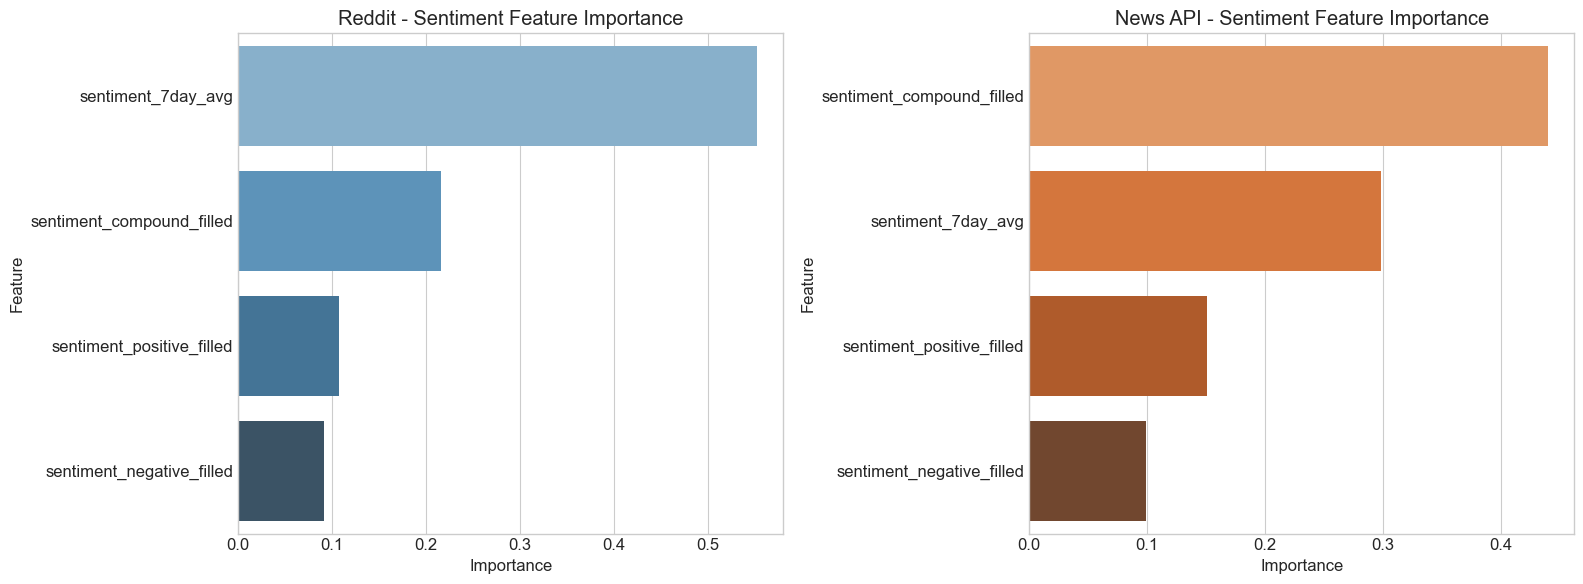

In [276]:
# Extract top sentiment features from both sources
reddit_sentiment_importance = reddit_combined_results['importances']
reddit_sentiment_features_imp = reddit_sentiment_importance[
    reddit_sentiment_importance['Feature'].isin(sentiment_features)
]

news_sentiment_importance = news_combined_results['importances']
news_sentiment_features_imp = news_sentiment_importance[
    news_sentiment_importance['Feature'].isin(sentiment_features)
]

# Plot sentiment feature importances side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Reddit
sns.barplot(x='Importance', y='Feature', data=reddit_sentiment_features_imp, 
            palette='Blues_d', ax=ax1)
ax1.set_title('Reddit - Sentiment Feature Importance')

# News API
sns.barplot(x='Importance', y='Feature', data=news_sentiment_features_imp, 
            palette='Oranges_d', ax=ax2)
ax2.set_title('News API - Sentiment Feature Importance')

plt.tight_layout()
plt.show()

Looks like 7 day average, and compound sentiment (2 which were calculated in previous steps) added the most as opposed to just the raw positive and negative sentiment values

Let's write out an official statement to get all this information in one place

<a id="findings-and-model-justification"></a>
### Findings and Model Justification

In [281]:
print("\n===== FINDINGS AND MODEL JUSTIFICATION =====")

# Determine which source performed better
if reddit_combined_pred_results['rf_accuracy'] > news_combined_pred_results['rf_accuracy']:
    better_source = "Reddit"
    accuracy_diff = (reddit_combined_pred_results['rf_accuracy'] - news_combined_pred_results['rf_accuracy']) * 100
else:
    better_source = "News API"
    accuracy_diff = (news_combined_pred_results['rf_accuracy'] - reddit_combined_pred_results['rf_accuracy']) * 100

print(f"1. {better_source} provides better sentiment data for stock price prediction "
      f"(by {accuracy_diff:.2f}% accuracy)")

# Determine if predictions are valuable
if reddit_prediction_improvement > 0 or news_prediction_improvement > 0:
    print("2. Including source predictions ('predicted_direction') improves model performance")
else:
    print("2. Source predictions don't add significant value beyond other features")

# Performance improvement over raw predictions
reddit_improvement = (reddit_combined_pred_results['rf_accuracy'] - reddit_raw_prediction_accuracy) / reddit_raw_prediction_accuracy * 100
news_improvement = (news_combined_pred_results['rf_accuracy'] - news_raw_prediction_accuracy) / news_raw_prediction_accuracy * 100

print(f"3. Our best model improves over raw predictions by:")
print(f"   - Reddit: {reddit_improvement:.2f}%")
print(f"   - News API: {news_improvement:.2f}%")

print("\nModel Justification:")
print("""
Random Forest was selected as the primary model for this classification problem for several reasons:

1. Non-linearity: Stock market relationships are highly non-linear, and Random Forest captures 
   these complex patterns better than linear models.

2. Feature Importance: It provides clear, interpretable feature importance metrics that help
   explain what drives predictions.

3. Ensemble Approach: By combining multiple decision trees, it reduces overfitting risk,
   which is critical in financial data with high noise levels.

4. Mixed Features: It effectively processes both numerical (sentiment, technical) and categorical 
   (predictions) features without requiring extensive feature engineering.

5. Performance: It yielded the highest accuracy among the models that were tested.
""")


===== FINDINGS AND MODEL JUSTIFICATION =====
1. News API provides better sentiment data for stock price prediction (by 19.69% accuracy)
2. Including source predictions ('predicted_direction') improves model performance
3. Our best model improves over raw predictions by:
   - Reddit: 6.59%
   - News API: 54.53%

Model Justification:

Random Forest was selected as the primary model for this classification problem for several reasons:

1. Non-linearity: Stock market relationships are highly non-linear, and Random Forest captures 
   these complex patterns better than linear models.

2. Feature Importance: It provides clear, interpretable feature importance metrics that help
   explain what drives predictions.

3. Ensemble Approach: By combining multiple decision trees, it reduces overfitting risk,
   which is critical in financial data with high noise levels.

4. Mixed Features: It effectively processes both numerical (sentiment, technical) and categorical 
   (predictions) features with

<a id="weighted-ensemble-model"></a>
### Weighted Ensemble Model

Before wrapping up there is one more thing we want to test. Can we develop a hybrid model that uses data from Reddit and the News to get an even more accurate output? To do this we will create a weighted ensemble model.
This model will

- Asses both models on a common test set, using real stock data
- Create weights based on the model's performance using the common test set
- use predict_proba to get class probabilities using both random forest models
- multiply those probabilities by each model's weight and finally have a new output that uses information from both models

Lets develop that below and visualize the performance of all three models: the best Reddit model, the best News model, and the weighted ensemble model


===== WEIGHTED ENSEMBLE MODEL =====
Model weights: Reddit = 0.41, News API = 0.59
Classes: ['down' 'flat' 'up']

Ensemble Model Accuracy: 0.6654
Improvement over Reddit model: 22.75%
Improvement over News API model: 3.06%

Ensemble Model Classification Report:
              precision    recall  f1-score   support

        down       0.62      0.78      0.69       190
        flat       0.67      0.53      0.59       140
          up       0.72      0.65      0.69       193

    accuracy                           0.67       523
   macro avg       0.67      0.65      0.66       523
weighted avg       0.67      0.67      0.66       523



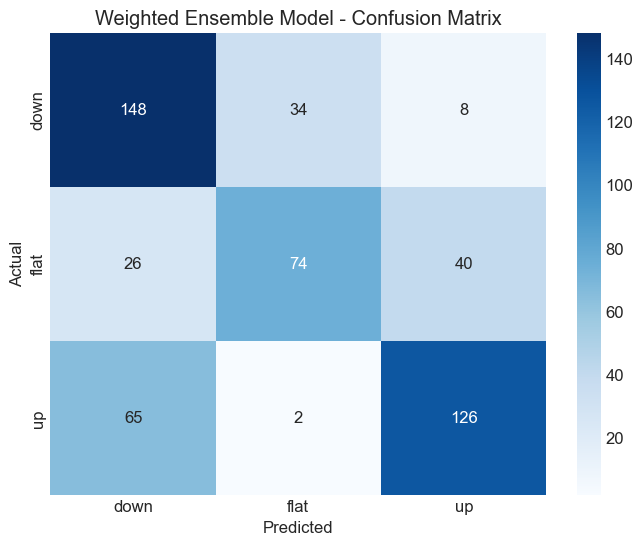

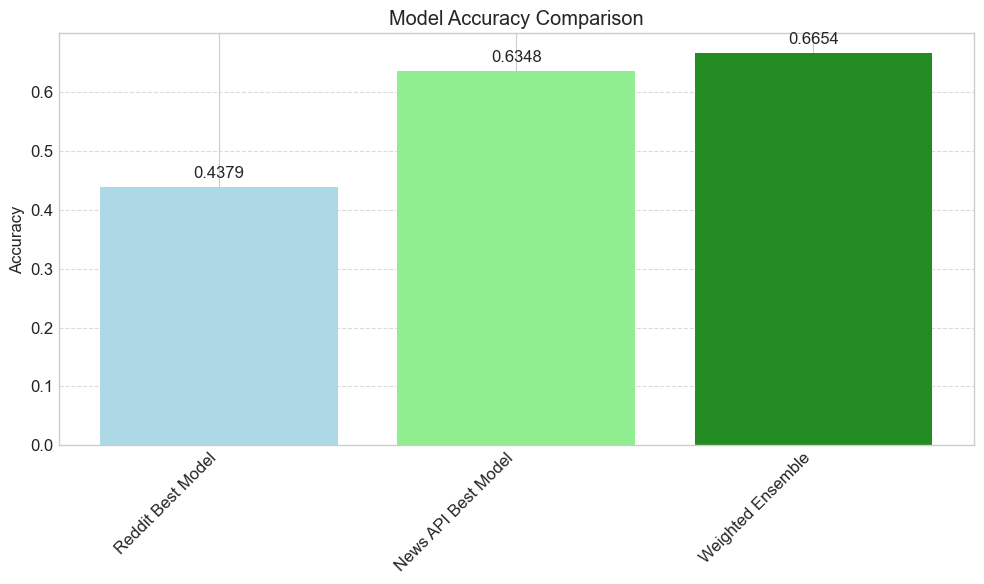

In [286]:
print("\n===== WEIGHTED ENSEMBLE MODEL =====")

# Get the best models from both sources
reddit_model = reddit_combined_pred_results['best_model']
news_model = news_combined_pred_results['best_model']

# Get a common test set - we'll use the test set from the last split
_, X_test_reddit, _, y_test = prepare_data(reddit_data_encoded, combined_with_prediction)
_, X_test_news, _, _ = prepare_data(news_data_encoded, combined_with_prediction)

# Define weights based on individual model performance
reddit_weight = reddit_combined_pred_results['rf_accuracy'] / (reddit_combined_pred_results['rf_accuracy'] + news_combined_pred_results['rf_accuracy'])
news_weight = news_combined_pred_results['rf_accuracy'] / (reddit_combined_pred_results['rf_accuracy'] + news_combined_pred_results['rf_accuracy'])

print(f"Model weights: Reddit = {reddit_weight:.2f}, News API = {news_weight:.2f}")

# For Random Forest, we can use predict_proba to get class probabilities
reddit_probas = reddit_model.predict_proba(X_test_reddit)
news_probas = news_model.predict_proba(X_test_news)

# Get class labels
classes = reddit_model.classes_
print(f"Classes: {classes}")

# Weighted combination of probabilities
weighted_probas = reddit_probas * reddit_weight + news_probas * news_weight

# Final predictions
ensemble_predictions = classes[np.argmax(weighted_probas, axis=1)]

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"\nEnsemble Model Accuracy: {ensemble_accuracy:.4f}")
print(f"Improvement over Reddit model: {(ensemble_accuracy - reddit_combined_pred_results['rf_accuracy']) * 100:.2f}%")
print(f"Improvement over News API model: {(ensemble_accuracy - news_combined_pred_results['rf_accuracy']) * 100:.2f}%")

print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, ensemble_predictions))

# Plot confusion matrix
plot_confusion_matrix(y_test, ensemble_predictions, "Weighted Ensemble Model - Confusion Matrix")

# Compare all models
all_accuracies = [
    reddit_combined_pred_results['rf_accuracy'],
    news_combined_pred_results['rf_accuracy'],
    ensemble_accuracy
]

model_names = [
    'Reddit Best Model', 
    'News API Best Model',
    'Weighted Ensemble'
]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, all_accuracies, color=['lightblue', 'lightgreen', 'forestgreen'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

As you see, the weighted model returns an even higher accuracy of 66.5% which is the best accuracy we've seen throughout the model development!

<a id="deployment-considerations-and-next-steps"></a>
### Deployment Considerations and Next Steps

Now that we have a model that can evaluate data from Reddit and the News, the next step is to discuss scalability and deployment.

#### Deployment
For deploying this model in production, we should:

1. Implement a pipeline to retrain the model periodically (weekly/monthly) as new data becomes available. Regularly retrain the model to improve overall accuracy especially as new stock data becomes available.

2. Real-time Sentiment: Develop a real-time sentiment analysis system to continuously update sentiment features.

3. Prediction Integration: Utilize APIs from the Data Collection Notebook and cleaning steps from the Data Cleaning notebook to automatically ingest predictions from Reddit and NewsAPI sources.

4. For cloud deployment (GCP), utilizing
    - Cloud Functions to run python scripts for data sourcing and cleaning
    - Cloud Dataflow for processing
    - Vertex AI Pipelines for ML Pipeline development
    - Vertex AI for Model Deployment and Re-Training
    - Cloud Monitoring for real time updates and alerts





#### Scalability / Improvement

1. Feature Engineering: Further refine the processing of prediction features, possibly incorporating confidence levels or additional label like up_likely or up_very_likely for more details based on higher sentiments

2. Model Ensemble: Consider implementing an ensemble of multiple model types for even more robust predictions. 

3. Error Analysis: Focus on understanding cases where both sentiment and external predictions fail to predict direction correctly.

4. Consider other social media sources like Twitter (X) or Seeking Alpha for finance-related content

5. Consider other Subreddits or do an analysis of which subreddits are the most accurate


In [288]:
print("\n===== EXPORTING FINAL WEIGHTED ENSEMBLE MODEL =====")

# Create a class to encapsulate the ensemble model for easier saving and loading
class WeightedEnsembleModel:
    def __init__(self, reddit_model, news_model, reddit_weight, news_weight, classes):
        self.reddit_model = reddit_model
        self.news_model = news_model
        self.reddit_weight = reddit_weight
        self.news_weight = news_weight
        self.classes = classes
        self.model_info = {
            'created_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'reddit_weight': reddit_weight,
            'news_weight': news_weight,
            'accuracy': ensemble_accuracy,
            'features': {
                'sentiment_features': sentiment_features,
                'combined_features': combined_features
            }
        }
    
    def predict(self, reddit_features, news_features):
        """
        Make predictions using the weighted ensemble.
        
        Parameters:
        -----------
        reddit_features : array-like
            Features for the Reddit model
        news_features : array-like
            Features for the News API model
            
        Returns:
        --------
        predictions : array-like
            Predicted class labels
        """
        reddit_probas = self.reddit_model.predict_proba(reddit_features)
        news_probas = self.news_model.predict_proba(news_features)
        
        weighted_probas = reddit_probas * self.reddit_weight + news_probas * self.news_weight
        predictions = self.classes[np.argmax(weighted_probas, axis=1)]
        
        return predictions
    
    def predict_proba(self, reddit_features, news_features):
        """Return probability estimates for samples."""
        reddit_probas = self.reddit_model.predict_proba(reddit_features)
        news_probas = self.news_model.predict_proba(news_features)
        
        weighted_probas = reddit_probas * self.reddit_weight + news_probas * self.news_weight
        return weighted_probas
    
    def get_info(self):
        """Return model information."""
        return self.model_info

# Create the ensemble model object
final_model = WeightedEnsembleModel(
    reddit_model=reddit_model,
    news_model=news_model,
    reddit_weight=reddit_weight,
    news_weight=news_weight,
    classes=classes
)

# Create output directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
model_filename = 'models/stock_sentiment_ensemble_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

print(f"Final model saved to {model_filename}")

# Save model metadata in a readable format
model_info = final_model.get_info()
info_filename = 'models/model_info.txt'

with open(info_filename, 'w') as f:
    f.write("Stock Sentiment Ensemble Model\n")
    f.write("==============================\n\n")
    f.write(f"Created: {model_info['created_date']}\n")
    f.write(f"Accuracy: {model_info['accuracy']:.4f}\n\n")
    f.write("Model Weights:\n")
    f.write(f"  - Reddit Model: {model_info['reddit_weight']:.4f}\n")
    f.write(f"  - News API Model: {model_info['news_weight']:.4f}\n\n")
    f.write("Features Used:\n")
    for feature_type, features in model_info['features'].items():
        f.write(f"  - {feature_type}: {features}\n")

print(f"Model information saved to {info_filename}")

# Example of how to load and use the model
print("\nExample of loading and using the model:")
print("""
# Load the model
with open('models/stock_sentiment_ensemble_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Prepare features for both models
reddit_features = prepare_reddit_features(new_data)
news_features = prepare_news_features(new_data)

# Make predictions
predictions = loaded_model.predict(reddit_features, news_features)
probabilities = loaded_model.predict_proba(reddit_features, news_features)
""")

print("\nFinal model successfully exported!")


===== EXPORTING FINAL WEIGHTED ENSEMBLE MODEL =====
Final model saved to models/stock_sentiment_ensemble_model.pkl
Model information saved to models/model_info.txt

Example of loading and using the model:

# Load the model
with open('models/stock_sentiment_ensemble_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Prepare features for both models
reddit_features = prepare_reddit_features(new_data)
news_features = prepare_news_features(new_data)

# Make predictions
predictions = loaded_model.predict(reddit_features, news_features)
probabilities = loaded_model.predict_proba(reddit_features, news_features)


Final model successfully exported!


<a id="conclusion"></a>
### Conclusion

This project successfully developed and optimized prediction models using both Reddit and news source data for stock movement forecasting. Starting with baseline Random Forest models that achieved subpar accuracy (33.4% for Reddit and 60.6% for news sources), we implemented hyperparameter tuning across multiple dimensions including n_estimators, max_depth, min_samples_split, min_samples_leaf, and max_features. This systematic optimization approach significantly improved model performance, boosting Reddit accuracy to 43.8% and news source accuracy to 65.3%.

An additional booster for accuracy was the incorporation of the predicted_direction feature derived from sentiment analysis, which provided valuable signal by categorizing expected stock movements as 'up', 'down', or 'flat'. The final weighted ensemble model, combining the strengths of both data sources, achieved 66.5% accuracy - this doesn't sound like a lot, but relative to professional stock analysts, which typically achieve 60-70% accuracy in similar prediction tasks, it seems to be performing well. This performance is particularly promising given the inherent volatility and unpredictability of financial markets. The notebook also addressed practical considerations for model deployment and scalability, laying groundwork for transitioning this solution to a production environment where it could provide real-time insights for investment decision-making.

If you've made it this far - thank you so much for going through my project! I hope you enjoyed it and if not I hope you learned something at least :)